# Analysis of results

In [1]:
# -- Libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.precision", 3)
pd.set_option("styler.format.precision", 3)

In [8]:
# -- Global configuration

SAVE_FIG = False
DIR_SAVE = "../tfm/figures/"

In [9]:
# -- Helper functions

def get_name_table(dataname):
    basename = os.path.basename(name)
    basename_split = basename.split("_")

    if "mixture" in dataname:
        model = "mixture"
    elif "gbm_" in dataname:
        model = "gbm"
    elif "gp_" in dataname:
        model = basename_split[5]
    else:
        model = basename_split[3]

    if "homoscedastic" in dataname:
        dataname_short = "Homoscedastic"
    elif "heteroscedastic" in dataname:
        dataname_short = "Heteroscedastic"
    elif "fractional" in dataname:
        dataname_short = "fBM"
    elif "brownian" in dataname:
        dataname_short = "BM"
    elif "exponential" in dataname:
        dataname_short = "Sq. exp"
    elif "ornstein_uhlenbeck" in dataname:
        dataname_short = "O-U"
    elif "gbm_rkhs" in dataname:
        dataname_short = "GBM + RKHS"
    elif "gbm_l2" in dataname:
        dataname_short = "GBM + $L^2$"
    else:
        dataname_short = model.capitalize()
        
    return dataname_short

def get_name_graph(dataname):
    basename = os.path.basename(dataname)
    basename_split = basename.split("_")
        
    if "mixture" in dataname:
        model = "mixture"
    elif "gbm_" in dataname:
        model = "gbm"
    elif "gp_" in dataname:
        model = basename_split[5]
    else:
        model = basename_split[3]

    real_data = False
    if "homoscedastic" in dataname:
        dataname_short = "BM(0, 1) vs. BM(m(t), 1)"
    elif "heteroscedastic" in dataname:
        dataname_short = "BM(0, 1) vs. BM(0, 2)"
    elif "fractional" in dataname:
        dataname_short = "Fractional Brownian"
    elif "brownian" in dataname:
        dataname_short = "Standard Brownian"
    elif "exponential" in dataname:
        dataname_short = "Gaussian"
    elif "ornstein_uhlenbeck" in dataname:
        dataname_short = "Ornstein-Uhlenbeck"
    elif "gbm_rkhs" in dataname:
        dataname_short = "Standard GBM + RKHS"
    elif "gbm_l2" in dataname:
        dataname_short = "Standard GBM + L2"
    else:
        dataname_short = model.capitalize()
        real_data = True

    if "smoothing" in basename:
        dataname_short += " - smooth"
    if "p_free" in basename:
        dataname_short += " (p free)"

    return dataname_short, real_data

def separate_df(df, key):
    df_bayesian = df[~df["Estimator"].str.contains("\+")]
    df_bayesian = df_bayesian.sort_values(key)
    df_var_sel = df[df["Estimator"].str.contains("\+")]
    df_var_sel = df_var_sel.sort_values(key)
    
    return df_bayesian, df_var_sel

## Dependence on parameters

In [361]:
# -- Configuration

DIR = "../Resultados/mixture_dependence_acc_p.csv"
X_LABEL = "p"

In [362]:
# -- Read data

df = pd.read_csv(DIR)
df_bayesian, df_var_sel = separate_df(df, X_LABEL)

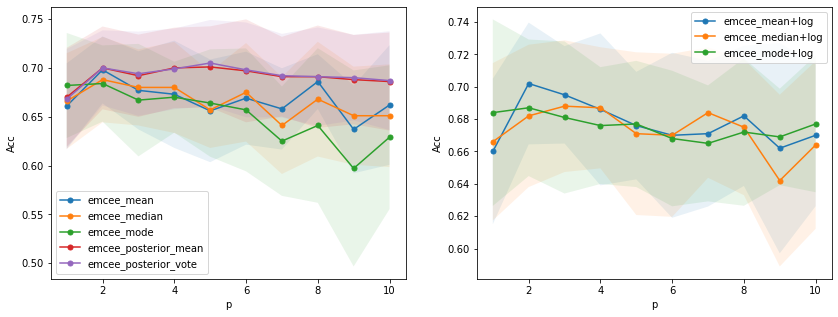

In [363]:
# -- Plot data

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
for i, df in enumerate([df_bayesian, df_var_sel]):
    ax[i].set_xlabel(X_LABEL)
    ax[i].set_ylabel("Acc")
    for key, grp in df.groupby(['Estimator']):
        x, y = grp[X_LABEL], grp['Mean Acc']
        yerror = grp['SD Acc']
        ax[i].plot(x, y, label=key, marker='.', markersize=10)
        ax[i].fill_between(x, y - yerror, y + yerror, alpha=0.1)

ax[0].legend()
ax[1].legend()

if SAVE_FIG:
    plt.savefig(
        DIR_SAVE + os.path.basename(DIR).split(".")[0], 
        bbox_inches='tight')

## CV results

In [57]:
# -- Configuration

KIND = "logistic"
METHOD = "emcee"
SMOOTHING = False
P_FREE = False
DIR = "../Resultados/results_140822_tau_uniform/out/"
SCORE_REG = "RMSE"  # RMSE or rRMSE

KIND_STR = "reg" if KIND == "linear" else "clf"
SCORE_STR = SCORE_REG if KIND == "linear" else "Acc"
SCORE_STR_FULL = SCORE_REG if KIND == "linear" else "accuracy"

### Data gathering

In [58]:
# -- Data reading functions

def get_filenames(*dirs, extension="csv"):
    rkhs = []
    l2 = []
    non_gp = []
    real = []

    dirs_lst = [d for d in dirs if d is not None]

    for dirname in dirs_lst:
        for file in os.listdir(dirname):
            filename = file.split(".")[0]
            ext = file.split(".")[1]

            if SMOOTHING and "smoothing" not in filename:
                continue
            if not SMOOTHING and "smoothing" in filename:
                continue
                
            if P_FREE and "p_free" not in filename:
                continue
            if not P_FREE and "p_free" in filename:
                continue

            if METHOD in filename and KIND_STR in filename and ext == extension:
                if KIND == "linear" and "gbm" in filename:
                    non_gp += [dirname + filename]
                elif KIND == "logistic" and "mixture" in filename:
                    non_gp += [dirname + filename]
                elif "rkhs" in filename:
                    rkhs += [dirname + filename]
                elif "l2" in filename:
                    l2 += [dirname + filename]
                else:
                    real += [dirname + filename]

    # Sort
    for dataset in [rkhs, l2, non_gp, real]:
        dataset.sort(key=lambda x: x.split("/")[-1])

    return rkhs, l2, non_gp, real

In [59]:
# -- Data reading

rkhs, l2, non_gp, real = get_filenames(DIR)

### Score tables

In [66]:
# -- Table configuration

PRINT_LATEX = True
dataname = "real"

if dataname == "rkhs":
    data_all = rkhs
elif dataname == "l2":
    data_all = l2
elif dataname == "nongp":
    data_all = non_gp
else:
    data_all = real

In [67]:
# -- Create tables

dfs_bayesian = []
dfs_var_sel = []

for name in data_all:
    kernel = get_name_table(name)
    df = pd.read_csv(name + ".csv")
    score_lst = [f"Mean {SCORE_STR}", f"SD {SCORE_STR}"]
    
    # Convert float to strings
    df[score_lst] = \
        df[score_lst].applymap(
            lambda x: "{:.3f}".format(x))

   # Join Mean and SD
    df[kernel] = df[score_lst[0]] + " (" + df[score_lst[1]] + ")"
    df = df[["Estimator", kernel]]

    df_bayesian, df_var_sel = separate_df(df, "Estimator")
    dfs_bayesian.append(df_bayesian)
    dfs_var_sel.append(df_var_sel)

In [68]:
# -- Show tables

print(
    "--> "
    + KIND.capitalize()
    + " " + METHOD
    + " " + dataname.upper()
    + (" (smooth)" if SMOOTHING else "")
    + " <--\n")

for dfs in [dfs_bayesian, dfs_var_sel]:
    df_merge = reduce(
        lambda df1, df2: df1.merge(df2, on="Estimator", how="inner"), 
        dfs)
    if PRINT_LATEX:
        print(df_merge.to_latex(index=False))
    else:
        display(df_merge)

--> Logistic emcee REAL <--

\begin{tabular}{llll}
\toprule
           Estimator &        Growth &      Medflies &       Phoneme \\
\midrule
          emcee\_mean & 0.858 (0.147) & 0.533 (0.041) & 0.763 (0.041) \\
        emcee\_median & 0.894 (0.112) & 0.573 (0.032) & 0.776 (0.044) \\
          emcee\_mode & 0.932 (0.034) & 0.582 (0.034) & 0.770 (0.056) \\
emcee\_posterior\_mean & 0.926 (0.032) & 0.596 (0.044) & 0.797 (0.035) \\
emcee\_posterior\_vote & 0.919 (0.046) & 0.575 (0.052) & 0.801 (0.031) \\
                fknn & 0.942 (0.040) & 0.534 (0.031) & 0.760 (0.046) \\
                flda & 0.945 (0.032) & 0.561 (0.020) & 0.781 (0.037) \\
                flog & 0.935 (0.050) & 0.601 (0.029) & 0.766 (0.041) \\
                 fnc & 0.735 (0.112) & 0.546 (0.038) & 0.703 (0.036) \\
                 lda & 0.894 (0.052) & 0.572 (0.019) & 0.618 (0.040) \\
                 log & 0.965 (0.030) & 0.575 (0.028) & 0.822 (0.026) \\
                 mdc & 0.700 (0.087) & 0.524 (0.026) & 0.663

<ipython-input-68-e6df499806c8>:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_merge.to_latex(index=False))
<ipython-input-68-e6df499806c8>:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_merge.to_latex(index=False))


### Score graphs

In [417]:
# -- Plotting functions

def plot_df(df, ax=None, legend=False, limit=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.margins(x=0.05)

    estimator = df["Estimator"].to_numpy(dtype=str)
    
    # Quick fix for name
    for i, name in enumerate(estimator):
        if "logistic" in name:
            estimator[i] = estimator[i].replace("+logistic", "+log")

    score = df["Mean " + SCORE_STR].to_numpy()
    sd = df["SD " + SCORE_STR].to_numpy()
    ours_idx = []

    # Outliers
    if KIND == "linear":
        if limit is None:
            q3, q1 = np.percentile(score + sd, [75 ,25])
            limit = q3 + 1.5*(q3 - q1)  # IQR
            
        outliers_idx = np.where(score > limit)[0]
        outliers = estimator[outliers_idx]
        symbol = ">"
    else:
        if limit is None:
            q3, q1 = np.percentile(score - sd, [75 ,25])
            limit = q1 - 1.5*(q3 - q1)  # IQR
        outliers_idx = np.where(score < limit)[0]
        outliers = estimator[outliers_idx]
        symbol = "<"

    # Plot our models
    all_outliers_ours = True
    for idx, idx_where in enumerate(np.char.find(estimator, METHOD)):
        if idx_where < 0:
            continue
        ours_idx.append(idx)

        if estimator[idx] in outliers:
            handles_ours_outliers = ax.plot(
                limit, estimator[idx], symbol, 
                color="darkorange", label="Our methods")
        else:
            all_outliers_ours = False
            handles_ours = ax.errorbar(
                score[idx],
                estimator[idx],
                xerr=sd[idx],
                color="darkorange",
                ecolor="darkorange",
                lw=1,
                fmt='o',
                markersize=5,
                label="Our methods"
            )

    estimator_rest = np.delete(estimator, ours_idx)
    score_rest = np.delete(score, ours_idx)
    sd_rest = np.delete(sd, ours_idx)

    # Plot comparison models
    all_outliers_rest = True
    for e, s, sdd in zip(estimator_rest, score_rest, sd_rest):
        if e in outliers:
            handles_rest_outliers = ax.plot(
                limit, e, symbol, color="navy", 
                label="Reference methods")
        else:
            all_outliers_rest = False
            handles_rest = ax.errorbar(
                s,
                e,
                xerr=sdd,
                color="navy",
                ecolor='navy',
                lw=1,
                fmt="o",
                markersize=5,
                label="Reference methods"
            )
            
    if all_outliers_ours:
        handles_ours = handles_ours_outliers
    if all_outliers_rest:
        handles_rest = handles_rest_outliers
    
    handles = [handles_ours, handles_rest]

    score_rest_no_outliers = np.delete(
        score, np.concatenate((outliers_idx, ours_idx)))
    if len(score_rest_no_outliers) > 0:
        handles_mean = ax.axvline(
            x=score_rest_no_outliers.mean(), color="teal", ls="--",
            lw=1.3, label=f"Mean of ref. methods")
        handles += [handles_mean]

    if legend:
        ax.legend(
            handles=handles,
            bbox_to_anchor=(1, 1))

    return handles


def plot_data_all(
    data,
    data_type_name,
    limit=None,
    legend=True,
    save=False,
    figsize=[None, None],
    bbox_legend=[None, None]
):
    n_data = len(data)
    if limit is None:
        limit = [(None, None)]*n_data

    if figsize[0] is None:
        figsize[0] = 3*n_data
    if figsize[1] is None:
        figsize[1] = 8
    if bbox_legend[0] is None:
        if n_data == 2:
            bbox_legend[0] = 1.15
        elif n_data == 3:
            bbox_legend[0] = 1.80
        elif n_data == 4:
            bbox_legend[0] = 2.45
        else:
            bbox_legend[0] = 1.0
    if bbox_legend[1] is None:
        bbox_legend[1] = -0.45

    fig = plt.figure(figsize=figsize)
    subfigs = fig.subfigures(nrows=1, ncols=n_data)
    if n_data == 1:
        subfigs = [subfigs]

    for j, (dataname, l) in enumerate(zip(data, limit)):
        df = pd.read_csv(dataname + ".csv")
        dataname_short, real_data = get_name_graph(dataname)

        # Get different strategies and order by score
        df_bayesian, df_var_sel = separate_df(df, "Estimator")

        ##
        # PLOT
        ##

        subfig = subfigs[j]
        subfig.suptitle(dataname_short, fontweight='semibold', y=0.96)
        ax1, ax2 = subfig.subplots(nrows=2, ncols=1)

        if j != 0 and j != n_data - 1:
            ax1.set_yticks([])
            ax2.set_yticks([])
        if j != 0 and j == n_data - 1:
            ax1.yaxis.tick_right()
            ax2.yaxis.tick_right()

        kind_title = 'Regression' if KIND == "linear" else 'Classification'
        ax1.set_title(f"{kind_title} methods", fontsize=10)
        ax2.set_title("Two-stage methods", fontsize=10)
        ax1.set_xlabel(SCORE_STR)
        ax2.set_xlabel(SCORE_STR)

        _ = plot_df(df_bayesian, ax1, legend=False, limit=l[0])
        handles = plot_df(df_var_sel, ax2, limit=l[1])

        if legend and j == 0:
            ax2.legend(
                loc="lower center",
                handles=handles,
                ncol=3,
                fancybox=True,
                shadow=True,
                fontsize=11,
                bbox_to_anchor=bbox_legend,
            )

        subfig.subplots_adjust(hspace=0.4)
        
    if save:
        filename_save = (
            ("reg_" if KIND == "linear" else "clf_")
            + METHOD + "_"
            + data_type_name
            + ("_p_free" if "p_free" in dataname else "")
            + ("_smooth" if "smoothing" in dataname else "")
            + ".png"
        )
        plt.savefig(DIR_SAVE + filename_save, bbox_inches='tight')

In [424]:
# -- Plot configuration

dataname = "rkhs"
limit = [(None, None), (None, None), (None, None), (1.0, None)]
bbox_legend = [None, None]
figsize = [10, 7]  # For use in LaTeX, [2.5*n_data, 7] works well

if dataname == "rkhs":
    data_all = rkhs
elif dataname == "l2":
    data_all = l2
elif dataname == "nongp":
    data_all = non_gp
else:
    data_all = real

--> Linear emcee RKHS <--


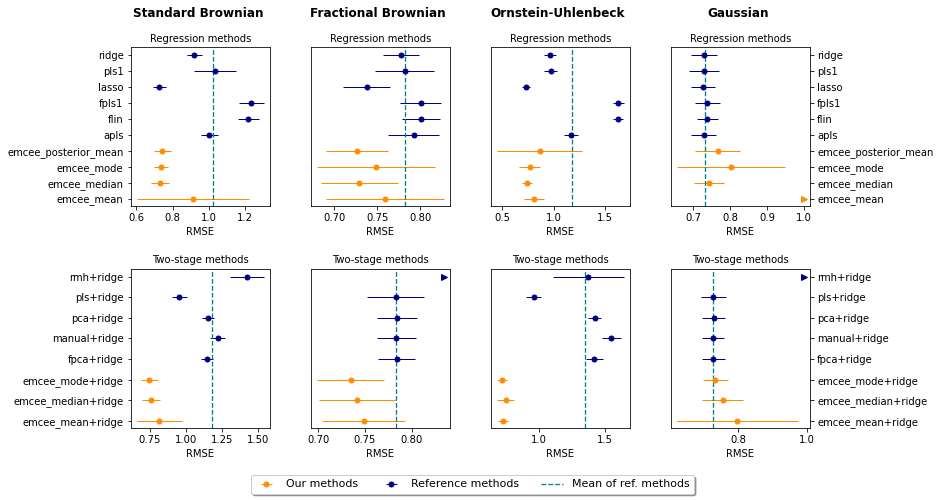

In [425]:
# -- Plot

print(
    "--> "
    + KIND.capitalize()
    + " " + METHOD
    + " " + dataname.upper()
    + (" (smooth)" if SMOOTHING else "")
    + " <--")

plot_data_all(
    data_all,
    dataname,
    limit=limit,
    legend=True,
    figsize=figsize,
    bbox_legend=bbox_legend,
    save=SAVE_FIG)

### CV data

In [95]:
rkhs, l2, non_gp, real = get_filenames(DIR, extension="npz")

In [96]:
# Example
arr = np.load(rkhs[0] + ".npz", allow_pickle=True)
print("Keys:")
for a in arr.keys():
    print(a)

Keys:
score_ref_all
score_bayesian_all
score_var_sel_all


In [97]:
# Each row is a different rep, inside the arrays are # n_splits x params_shape
# e.g. for 5 folds, p in [2, 3] and eta in [0.01, 0.1], shape is (5, 2, 2).
arr["score_bayesian_all"]

# There are also the parameter vectors (eta, p) and, in the case of INCLUDE_P,
# the effective n_components used in each case.

array([{'posterior_mean': array([[[0.6667, 0.6667, 0.7   , 0.6667, 0.6667, 0.6667, 0.6667],
               [0.7   , 0.6667, 0.7   , 0.7   , 0.6667, 0.7   , 0.7   ],
               [0.7   , 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667],
               [0.7   , 0.7   , 0.7   , 0.7   , 0.7   , 0.7   , 0.7   ],
               [0.6667, 0.7   , 0.7333, 0.7   , 0.7   , 0.7   , 0.7   ],
               [0.7333, 0.7333, 0.7333, 0.7   , 0.7333, 0.6667, 0.6667],
               [0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667],
               [0.7   , 0.7333, 0.7333, 0.7   , 0.6667, 0.6667, 0.7   ],
               [0.7   , 0.7333, 0.7333, 0.7   , 0.7   , 0.7333, 0.6667],
               [0.7   , 0.6667, 0.7333, 0.7   , 0.7   , 0.7667, 0.7   ]],

              [[0.7333, 0.7333, 0.7333, 0.7333, 0.7333, 0.7333, 0.7333],
               [0.8   , 0.7667, 0.8   , 0.8   , 0.7667, 0.8   , 0.8   ],
               [0.8   , 0.8   , 0.8   , 0.8   , 0.8   , 0.7333, 0.7667],
               [0.8   , 0.8   